## Forecasting forex using ARIMA for USD/VND 
The purpose of this research is to forecast usd/vnd exchamge rate to use in our investment analysis.

# Import packages

In [4]:
# Import packages
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from pandas_datareader import data as wb
from matplotlib import pyplot

from pmdarima.arima import auto_arima
from datetime import datetime
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Set figure parameters
plt.rcParams['figure.figsize'] = [10, 7.5]

## Input data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


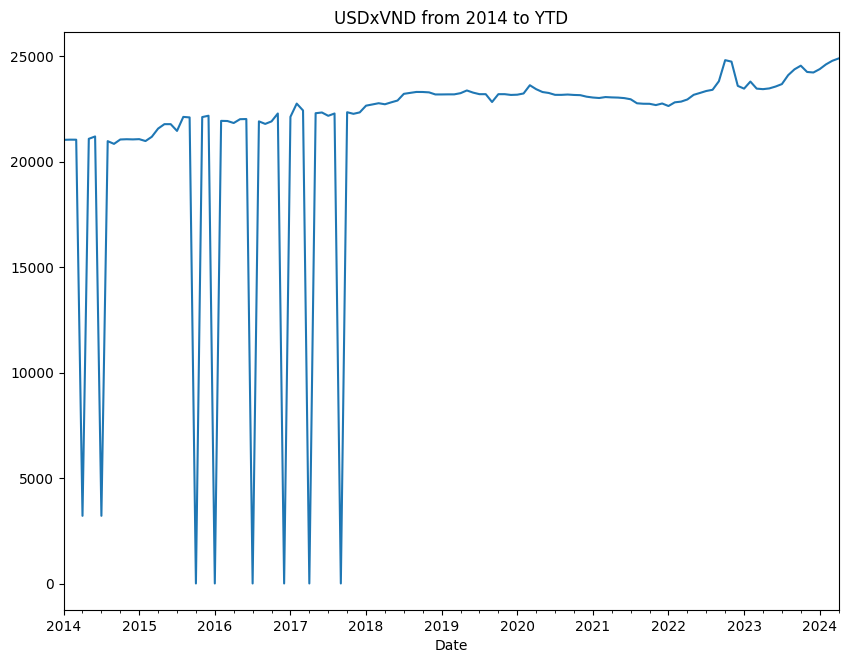

In [5]:
yf.pdr_override()

data = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31', interval = '1mo')

# Obtain latest vnd to usd rate
df_conv = wb.get_data_yahoo('VND=x', start = '2014-01-01', end = '2024-12-31')
data1 = 1/df_conv
vnd_to_usd = data1.iloc[-1,0]

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2014 to YTD")
plt.show()

df = pd.DataFrame(data['Adj Close']) 


## Stationary test

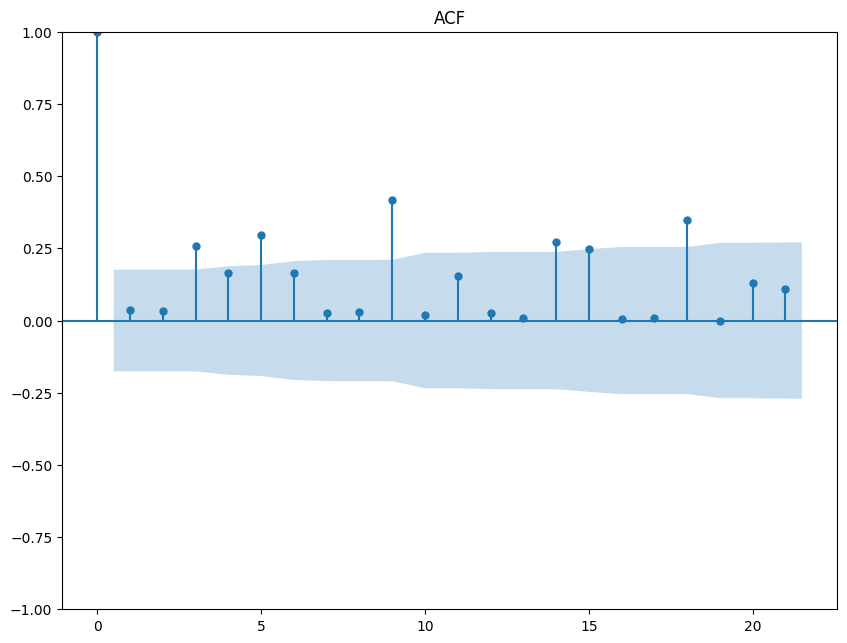

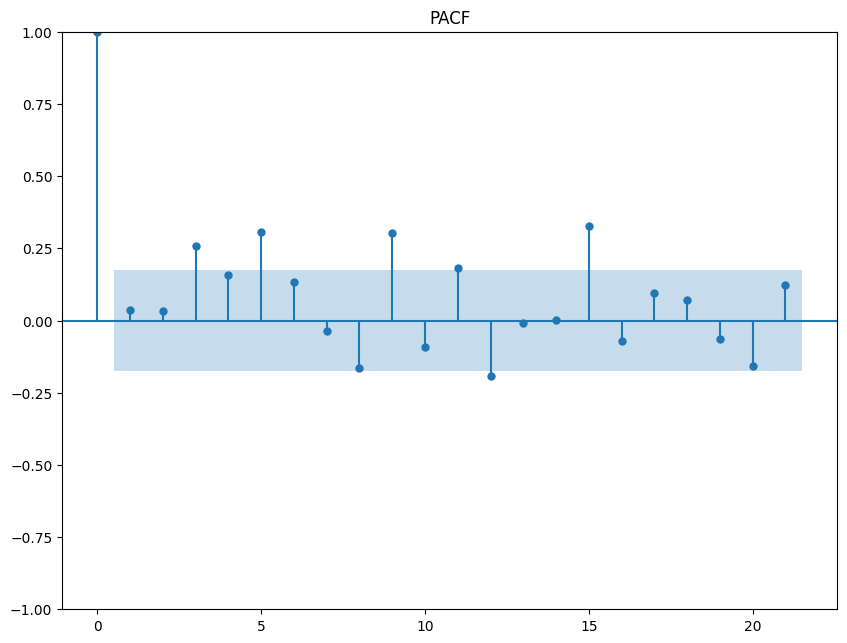

In [6]:
# Autocorrelation and partial correlation function of data
plot_acf(df['Adj Close'])
plt.title("ACF")
plot_pacf(df['Adj Close'])
plt.title("PACF")
plt.show()

In [7]:
adftest = adfuller(df['Adj Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.694076402421576
P-Value: 0.23855032091165967
Number of lags: 11
Number of observations: 112
Critical Values: {'1%': -4.041963001634247, '5%': -3.4504426407047193, '10%': -3.1504645425245994}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


## Differencing 

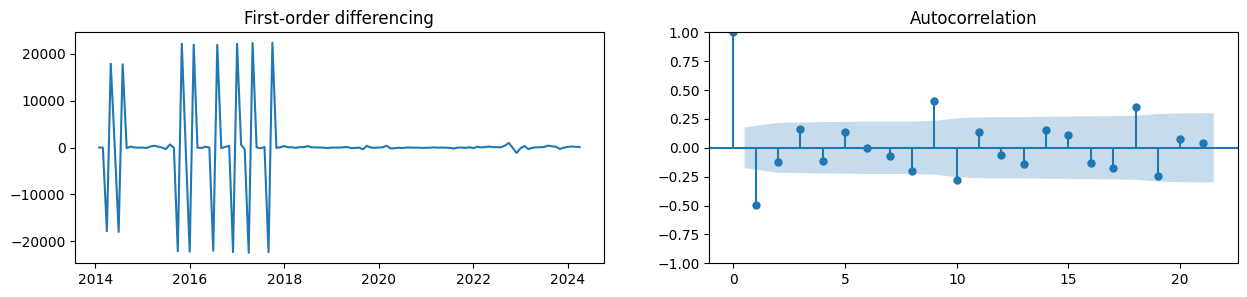

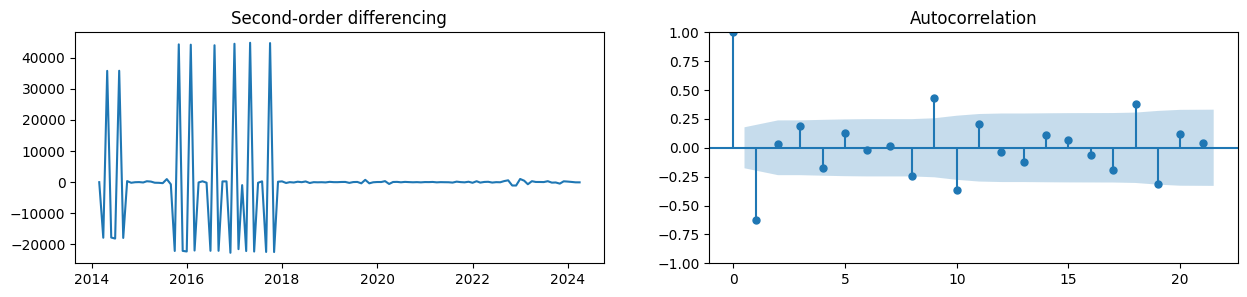

In [8]:
# First-order differencing
df['diff1'] = df['Adj Close'].diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(df['diff1'])

df['growth_1'] = df['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
df['diff2'] = df['Adj Close'].diff().diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(df['diff2'])

df['growth_2'] = df['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff2'].dropna(), ax=ax2)
plt.show()



In [9]:
# Test stationarity with ADF
adftest = adfuller(df['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -4.839762416858773
P-Value: 2.1627674691704924e-06
Number of lags: 13
Number of observations: 109
Critical Values {'1%': -2.586557203939062, '5%': -1.9437233356164225, '10%': -1.6145921490406778}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


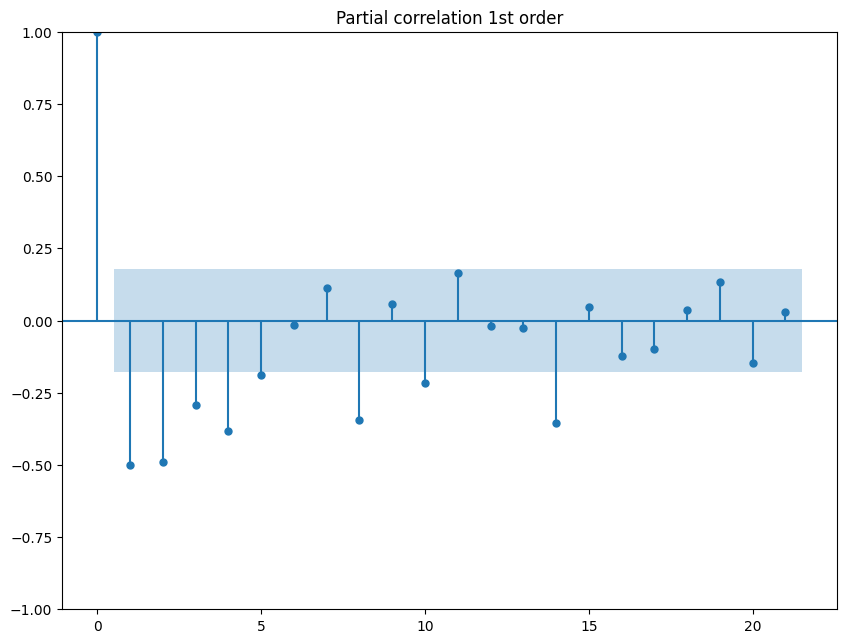

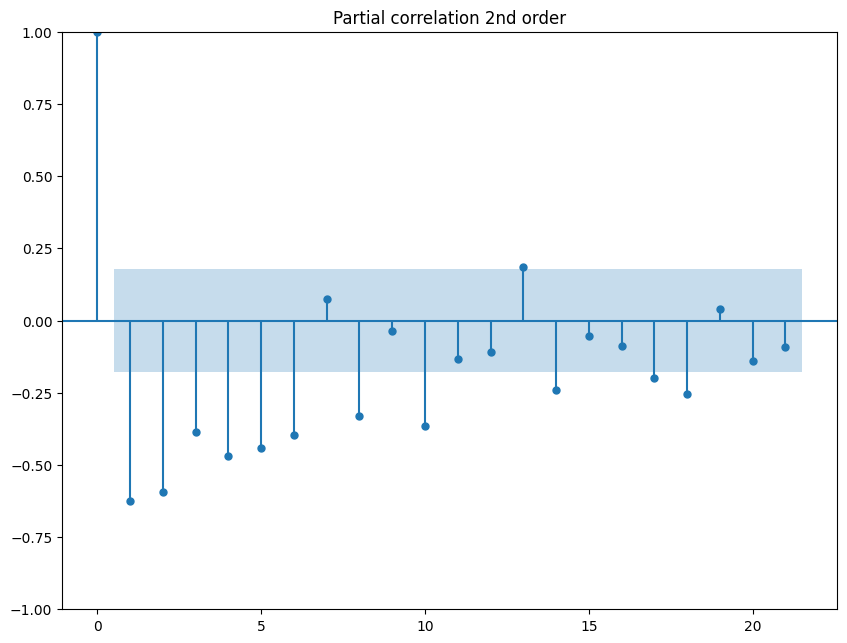

In [10]:
# Partial autocorrelation
plot_pacf(df['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(df['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

# ARIMA model parameters

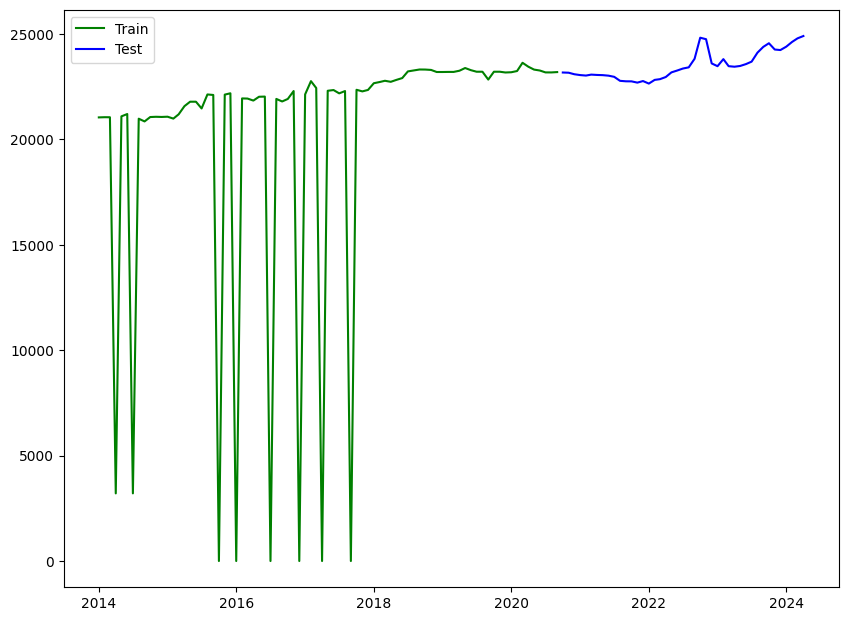

In [32]:
# Seperate into train and test data
to_row = int(len(df)*0.66)

df_train = list(df[0:to_row]['Adj Close'])
df_test = list(df[to_row:]['Adj Close'])

# Plot
plt.plot(df[0:to_row]['Adj Close'], 'green', label='Train')
plt.plot(df[to_row:]['Adj Close'],'blue',label='Test')
plt.legend()
plt.show()

In [119]:
# Finding ARIMA parameters automatically
model = auto_arima(df[0:to_row]['Adj Close'].dropna(), seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(0, 1, 3)


In [120]:
model_predictions = []
n_test_obser = len(df_test)

p = 2
d = 1
q = 5

for i in range(n_test_obser):
    model = ARIMA(df_train, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)
    model_predictions.append(yhat)
    actual_test_value = df_test[i]
    df_train.append(actual_test_value)

In [121]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  381
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -3547.095
Date:                Wed, 03 Apr 2024   AIC                           7110.190
Time:                        11:02:39   BIC                           7141.712
Sample:                             0   HQIC                          7122.698
                                - 381                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0705      0.115      0.611      0.541      -0.156       0.297
ar.L2          0.5310      0.067      7.954      0.000       0.400       0.662
ma.L1         -1.0475      0.141     -7.435      0.000      -1.324      -0.771
ma.L2         -0.7333      0.142     -5.158      0.000      -1.012      -0.455
ma.L3          1.2034      0.076     15.905      0.000       1.055       1.352
ma.L4         -0.2474      0.113     -2.195      0.028      -0.468      -0.026
ma.L5         -0.1371      0.060     -2.289      0.022      -0.255      -0.020
sigma2      7.967e+06   5.08e-08   1.57e+14      0.000    7.97e+06    7.97e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6747.24
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+29. Standard errors may be unstable.
"""

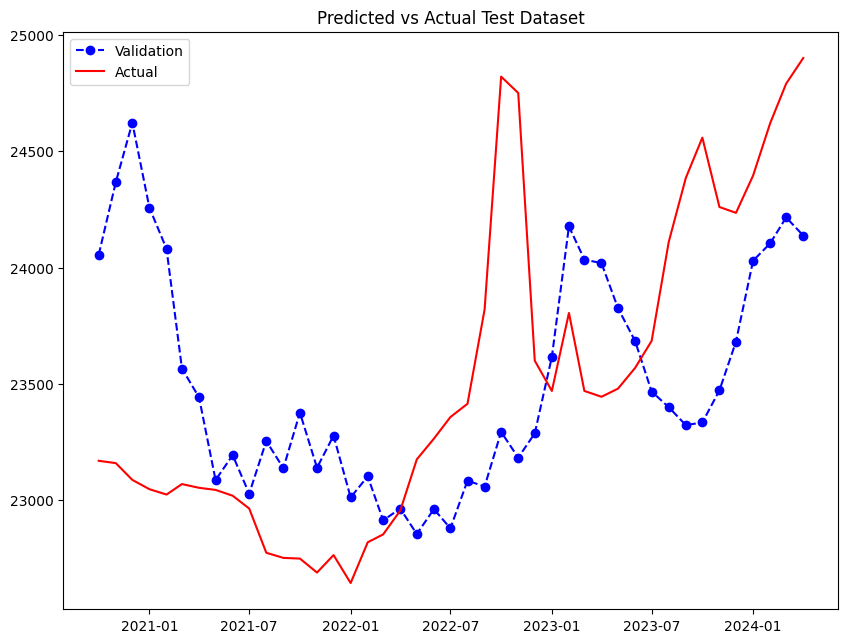

In [145]:
date_range = df[to_row:].index
plt.plot(date_range, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(date_range, df_test, color = 'red', label = 'Actual')
plt.legend()
plt.title('Predicted vs Actual Test Dataset')
plt.show()

# Evaluate model predictions

In [123]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, model_predictions)*vnd_to_usd
mape = mean_absolute_percentage_error(df_test, model_predictions)*vnd_to_usd
mse = (mean_squared_error(df_test, model_predictions))*vnd_to_usd
rmse = np.sqrt(mean_squared_error(df_test, model_predictions))*vnd_to_usd

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.023167449158354208
mse: 20.060834326543837
mape: 9.781368038142735e-07
rmse: 0.028435516000157927


In [124]:
testScore = np.sqrt(mean_squared_error(df_test, model_predictions))

testScore = testScore*vnd_to_usd

print('Test Score: %.6f RMSE' % (testScore))

Test Score: 0.028436 RMSE


# Forecast into the future

In [125]:
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

print("Forecasted values:")
print(forecast)

Forecasted values:
[24137.56486238 24215.89986207 24386.64420676 24228.26502764
 24229.31432932 24145.28509759 24139.91501692 24094.91462698
 24088.88872726 24064.56735386 24059.65186235 24046.38988282]


In [126]:
from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1] + DateOffset(months = x) for x in range (0,forecast_steps+1)]
future_dates_df = pd.DataFrame(index = future_dates[1:], columns = df.columns)
comb_df = pd.concat([df[to_row:], future_dates_df])

C:\Users\User\AppData\Local\Temp\ipykernel_12012\756363568.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comb_df = pd.concat([df[to_row:], future_dates_df])


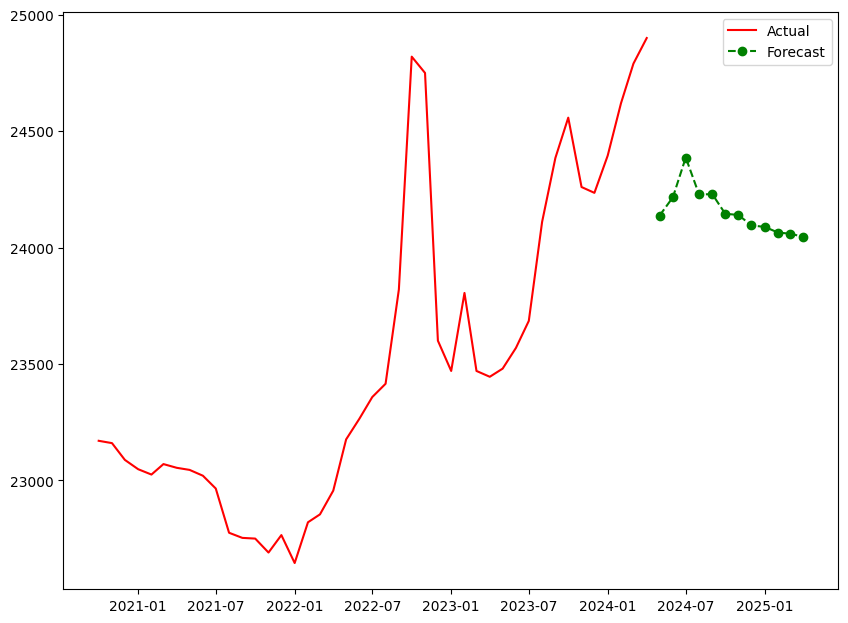

In [146]:
plt.plot(df[to_row:].index, df[to_row:]['Adj Close'], color = 'red', label = 'Actual')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

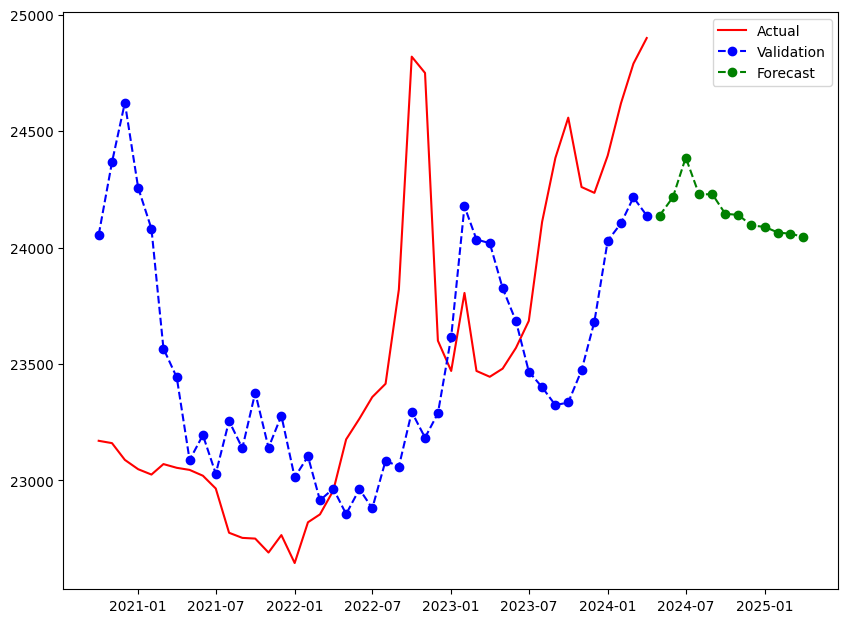

In [147]:
plt.plot(df[to_row:].index, df[to_row:]['Adj Close'], color = 'red', label = 'Actual')
plt.plot(df[to_row:].index, model_predictions, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'Validation')
plt.plot(future_dates_df.index, forecast, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Forecast')
plt.legend()

# Check fit